
# Confounded vs deconfounded model comparison

Train multiple classifiers on a confounded dataset and several pre-generated deconfounded datasets (e.g., backdoor, frontdoor, truncated factorisation). Compare their predictive metrics on a shared observational hold-out and on each deconfounded hold-out.



**Workflow**
1. Load confounded CSV and multiple deconfounded CSVs (already generated; no bootstrap here).
2. Align feature columns common to all datasets and split each into train/test.
3. Fit a set of common models on each training set.
4. Evaluate on the same confounded hold-out to see how deconfounding affects generalization to observational data.
5. Also evaluate on each deconfounded hold-out for interventional-like performance.

> Set DECONFOUNDED_DATASETS below to your deconfounded files (same schema + target).


In [21]:

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone


In [22]:

# === Paths & columns ===
CONFOUNDED_PATH = 'heart_disease_preprocessed.csv'
DECONFOUNDED_DATASETS = [
    {'name': 'Backdoor', 'path': 'heart_disease_preprocessed_backdoor.csv'},
    {'name': 'Frontdoor', 'path': 'heart_disease_preprocessed_frontdoor.csv'},
    {'name': 'TruncatedFactorisation', 'path': 'heart_disease_preprocessed_tf.csv'},
]

TARGET = 'heartdiseasepresence'
TEST_SIZE = 0.2
RANDOM_SEED = 42

assert Path(CONFOUNDED_PATH).exists(), f"Confounded file not found: {CONFOUNDED_PATH}"
for ds in DECONFOUNDED_DATASETS:
    assert Path(ds['path']).exists(), f"Deconfounded file not found: {ds['path']}"


In [23]:
#Here I am doing basic checks to ensure that all datasets have the same columns and target distributions
# Load datasets
df_conf = pd.read_csv(CONFOUNDED_PATH)
deconf_dfs = {}
for ds in DECONFOUNDED_DATASETS:
    tempdf = pd.read_csv(ds['path'])
    tempdf.columns = [col.replace('[', '_').replace(']', '').replace('<', 'lt').replace('>', 'gt') for col in tempdf.columns]
    deconf_dfs[ds['name']] = tempdf

# Align columns across all datasets (intersection to ensure comparability)
common_cols = set(df_conf.columns)
for name, df in deconf_dfs.items():
    common_cols = common_cols.intersection(set(df.columns))
assert TARGET in common_cols, f"Target '{TARGET}' must exist in all datasets"

feature_cols = sorted([c for c in common_cols if c != TARGET])

df_conf = df_conf[feature_cols + [TARGET]]
for name in deconf_dfs:
    deconf_dfs[name] = deconf_dfs[name][feature_cols + [TARGET]]

print('Common features:', len(feature_cols))
print('Confounded shape:', df_conf.shape)
for name, df in deconf_dfs.items():
    print(f"Deconfounded ({name}) shape: {df.shape}")

print('Confounded target balance:', df_conf[TARGET].value_counts())
for name, df in deconf_dfs.items():
    print(f"Deconfounded ({name}) target balance:", df[TARGET].value_counts())

df_conf.head()

Common features: 23
Confounded shape: (272, 24)
Deconfounded (Backdoor) shape: (544, 24)
Deconfounded (Frontdoor) shape: (544, 24)
Deconfounded (TruncatedFactorisation) shape: (544, 24)
Confounded target balance: 0    136
1    136
Name: heartdiseasepresence, dtype: int64
Deconfounded (Backdoor) target balance: 0    272
1    272
Name: heartdiseasepresence, dtype: int64
Deconfounded (Frontdoor) target balance: 0    272
1    272
Name: heartdiseasepresence, dtype: int64
Deconfounded (TruncatedFactorisation) target balance: 0    272
1    272
Name: heartdiseasepresence, dtype: int64


,age,ca,chol,cp_Asymptomatic,cp_AtypicalAngina,cp_NonAnginalPain,cp_TypicalAngina,exang_NoExAngina,exang_YesExAngina,oldpeak,...,sex_Male,slope_Downsloping,slope_Flat,slope_Upsloping,thal_FixedDefect,thal_Normal,thal_ReversibleDefect,thalach,trestbps,heartdiseasepresence
0,0.950883,-0.740979,-0.289108,0,0,0,1,1,0,1.180495,...,1,1,0,0,1,0,0,0.040935,0.743598,0
1,1.397584,2.527338,0.785340,1,0,0,0,0,1,0.647625,...,1,0,1,0,0,1,0,-1.757678,1.593663,1
2,1.397584,1.437899,-0.370199,1,0,0,0,0,1,1.347500,...,1,0,1,0,0,0,1,-0.858371,-0.673176,1
3,-1.952676,-0.740979,0.055526,0,0,1,0,1,0,1.775790,...,1,1,0,0,0,1,0,1.625427,-0.106466,0
4,-1.505975,-0.740979,-0.877014,0,1,0,0,1,0,0.569273,...,0,0,0,1,0,1,0,0.983065,-0.106466,0


In [24]:

# Train/test splits for each dataset
splits = {
    'Confounded': {
        'train': None,
        'test': None,
        'label': 'Confounded (observational)'
    }
}

conf_train, conf_test = train_test_split(
    df_conf, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=df_conf[TARGET]
)
splits['Confounded']['train'] = conf_train
splits['Confounded']['test'] = conf_test

for name, df in deconf_dfs.items():
    train_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=df[TARGET]
    )
    splits[name] = {'train': train_df, 'test': test_df, 'label': f'Deconfounded ({name})'}

for name, split in splits.items():
    print(name, 'train/test sizes:', len(split['train']), len(split['test']))


Confounded train/test sizes: 217 55
Backdoor train/test sizes: 435 109
Frontdoor train/test sizes: 435 109
TruncatedFactorisation train/test sizes: 435 109



### Models and evaluation helpers

Metrics: Accuracy, ROC AUC, PR AUC (average precision), Brier score, and log loss.


In [25]:

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, penalty='l2', C=0.1, solver='liblinear', random_state=RANDOM_SEED),
    'RandomForest': RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=RANDOM_SEED),
    'SVC': SVC(kernel='linear', C=1.0, gamma='scale', random_state=RANDOM_SEED),
    'MLPClassifier': MLPClassifier(
        activation='relu',
        alpha=0.0001,
        hidden_layer_sizes=(50,),
        learning_rate='constant',
        solver='adam',
        max_iter=500,
        random_state=RANDOM_SEED
    ),
    'XGBoost': XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=300,
        subsample=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_SEED
    )
}

def get_probas(model, X):
    if hasattr(model, 'predict_proba'):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, 'decision_function'):
        scores = model.decision_function(X)
        return 1 / (1 + np.exp(-scores))
    raise ValueError('Model does not support probability-like outputs')


In [26]:
def evaluate_model(model, X_train, y_train, X_eval, y_eval):
    from sklearn.base import clone
    m = clone(model)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_eval)
    y_proba = get_probas(m, X_eval)
    metrics = {
        'accuracy': accuracy_score(y_eval, y_pred),
        'roc_auc': roc_auc_score(y_eval, y_proba),
        'pr_auc': average_precision_score(y_eval, y_proba),
        'brier': brier_score_loss(y_eval, y_proba),
        'log_loss': log_loss(y_eval, y_proba),
    }
    return metrics

In [27]:

# Evaluate all train/eval combinations
results = []

# Evaluation sets: always include the confounded test, plus each deconfounded test
eval_sets = [('Confounded', splits['Confounded']['test'])]
for name, split in splits.items():
    if name == 'Confounded':
        continue
    eval_sets.append((name, split['test']))

for model_name, model in models.items():
    for train_name, split in splits.items():
        X_train = split['train'][feature_cols]
        y_train = split['train'][TARGET]

        for eval_name, eval_df in eval_sets:
            X_eval = eval_df[feature_cols]
            y_eval = eval_df[TARGET]
            metrics = evaluate_model(model, X_train, y_train, X_eval, y_eval)
            metrics.update({
                'model': model_name,
                'training_data': splits[train_name]['label'],
                'evaluation': 'Confounded test' if eval_name == 'Confounded' else f'Deconfounded test ({eval_name})'
            })
            results.append(metrics)

results_df = pd.DataFrame(results)
results_df


c:\Users\jeenu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jeenu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jeenu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jeenu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

,accuracy,roc_auc,pr_auc,brier,log_loss,model,training_data,evaluation
0,0.836364,0.919312,0.936970,0.115298,0.364927,LogisticRegression,Confounded (observational),Confounded test
1,0.844037,0.935017,0.950022,0.103115,0.343637,LogisticRegression,Confounded (observational),Deconfounded test (Backdoor)
2,0.733945,0.782492,0.776477,0.189841,0.602555,LogisticRegression,Confounded (observational),Deconfounded test (Frontdoor)
3,0.541284,0.512795,0.533096,0.341639,1.027802,LogisticRegression,Confounded (observational),Deconfounded test (TruncatedFactorisation)
4,0.854545,0.924603,0.943274,0.105033,0.339924,LogisticRegression,Deconfounded (Backdoor),Confounded test
...,...,...,...,...,...,...,...,...
75,0.541284,0.554209,0.556863,0.287409,0.802565,XGBoost,Deconfounded (Frontdoor),Deconfounded test (TruncatedFactorisation)
76,0.581818,0.593915,0.569977,0.241854,0.676422,XGBoost,Deconfounded (TruncatedFactorisation),Confounded test
77,0.623853,0.610438,0.633194,0.234684,0.661092,XGBoost,Deconfounded (TruncatedFactorisation),Deconfounded test (Backdoor)
78,0.532110,0.594613,0.543387,0.243540,0.679704,XGBoost,Deconfounded (TruncatedFactorisation),Deconfounded test (Frontdoor)



### Combined, tidy comparison table


In [28]:

def tidy(df):
    cols = ['model', 'training_data', 'evaluation', 'accuracy', 'roc_auc', 'pr_auc', 'brier', 'log_loss']
    return df[cols].sort_values(['evaluation', 'model', 'training_data']).reset_index(drop=True)

tidy(results_df)


,model,training_data,evaluation,accuracy,roc_auc,pr_auc,brier,log_loss
0,LogisticRegression,Confounded (observational),Confounded test,0.836364,0.919312,0.936970,0.115298,0.364927
1,LogisticRegression,Deconfounded (Backdoor),Confounded test,0.854545,0.924603,0.943274,0.105033,0.339924
2,LogisticRegression,Deconfounded (Frontdoor),Confounded test,0.800000,0.874339,0.900088,0.151563,0.470294
3,LogisticRegression,Deconfounded (TruncatedFactorisation),Confounded test,0.690909,0.702381,0.680805,0.232942,0.658793
4,MLPClassifier,Confounded (observational),Confounded test,0.836364,0.902116,0.924682,0.126185,0.419723
...,...,...,...,...,...,...,...,...
75,SVC,Deconfounded (TruncatedFactorisation),Deconfounded test (TruncatedFactorisation),0.458716,0.444781,0.463663,0.303516,0.809181
76,XGBoost,Confounded (observational),Deconfounded test (TruncatedFactorisation),0.532110,0.503030,0.501988,0.355663,1.086334
77,XGBoost,Deconfounded (Backdoor),Deconfounded test (TruncatedFactorisation),0.568807,0.526936,0.526097,0.341945,1.035898
78,XGBoost,Deconfounded (Frontdoor),Deconfounded test (TruncatedFactorisation),0.541284,0.554209,0.556863,0.287409,0.802565



### Visualize observational (confounded) test accuracy


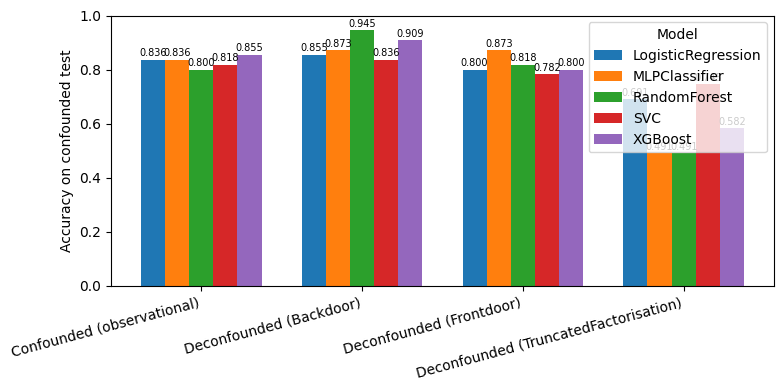

In [29]:

import matplotlib.pyplot as plt

plot_df = results_df[results_df['evaluation'] == 'Confounded test'].copy()
fig, ax = plt.subplots(figsize=(8, 4))

train_labels = plot_df['training_data'].unique()
train_labels_sorted = sorted(train_labels)
x_pos = np.arange(len(train_labels_sorted))

width = 0.15
for idx, model_name in enumerate(sorted(plot_df['model'].unique())):
    subset = plot_df[plot_df['model'] == model_name].set_index('training_data').loc[train_labels_sorted]
    bars = ax.bar(x_pos + idx * width, subset['accuracy'], width=width, label=model_name)
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{bar.get_height():.3f}",
                ha='center', va='bottom', fontsize=7)

ax.set_xticks(x_pos + width * (len(plot_df['model'].unique()) - 1) / 2)
ax.set_xticklabels(train_labels_sorted, rotation=15, ha='right')
ax.set_ylabel('Accuracy on confounded test')
ax.set_ylim(0, 1)
ax.legend(title='Model')
plt.tight_layout()
plt.show()
